<a href="https://colab.research.google.com/github/mr-cri-spy/learning_days/blob/main/using_reinforcement__stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Price             Open        High         Low       Close     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  128.924245  129.537788  122.877827  123.768463  112117500
2023-01-04  125.569520  127.321104  123.778358  125.045036   89113600
2023-01-05  125.807014  126.440353  123.461682  123.718971   80962700
2023-01-06  124.698692  128.934144  123.590345  128.271118   87754700
2023-01-09  129.112255  132.021662  128.538289  128.795578   70790800
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


<ipython-input-7-0bb3a3983651>:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  open_price = float(self.data.iloc[self.current_step]['Open'])
<ipython-input-7-0bb3a3983651>:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  high_price = float(self.data.iloc[self.current_step]['High'])
<ipython-input-7-0bb3a3983651>:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  low_price = float(self.data.iloc[self.current_step]['Low'])
<ipython-input-7-0bb3a3983651>:50: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  close_price = float(self.data.iloc[self.current_step]['Close'])


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 249      |
|    ep_rew_mean      | 4.54e+03 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 328      |
|    time_elapsed     | 3        |
|    total_timesteps  | 996      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 34.8     |
|    n_updates        | 223      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 249      |
|    ep_rew_mean      | 2.8e+03  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 316      |
|    time_elapsed     | 6        |
|    total_timesteps  | 1992     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 14.3     |
|    n_updates      

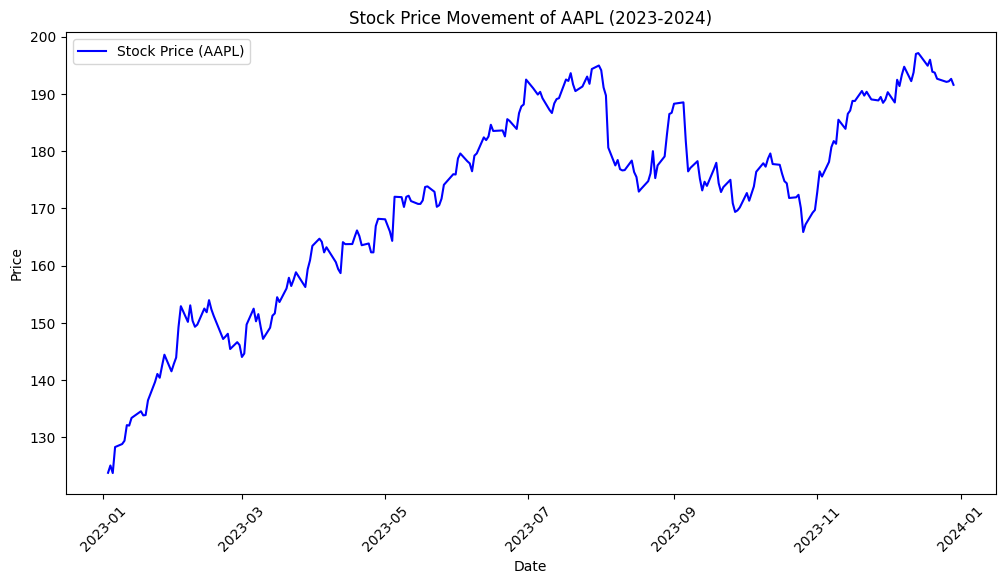

In [7]:
import gym
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from gym import spaces

# Download stock data from Yahoo Finance
def get_stock_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Example: Get Apple's stock data for the last 1 year
stock_data = get_stock_data('AAPL', '2023-01-01', '2024-01-01')
print(stock_data.head())  # Print first 5 rows

# Reset index to avoid index-related issues
stock_data = stock_data.reset_index()

# Define the custom trading environment
class StockTradingEnv(gym.Env):
    def __init__(self, data, initial_balance=10000):
        super(StockTradingEnv, self).__init__()
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.total_value = initial_balance

        # Define action space: 0 = Hold, 1 = Buy, 2 = Sell
        self.action_space = spaces.Discrete(3)

        # Define observation space (Open, High, Low, Close, Balance, Shares Held)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(6,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.total_value = self.initial_balance
        return self._next_observation()

    def _next_observation(self):
        # Extract data for the current step
        open_price = float(self.data.iloc[self.current_step]['Open'])
        high_price = float(self.data.iloc[self.current_step]['High'])
        low_price = float(self.data.iloc[self.current_step]['Low'])
        close_price = float(self.data.iloc[self.current_step]['Close'])

        # Convert balance and shares_held to float32
        balance = np.float32(self.balance)
        shares_held = np.float32(self.shares_held)

        # Return the observation as a NumPy array
        obs = np.array([open_price, high_price, low_price, close_price, balance, shares_held], dtype=np.float32)
        return obs

    def step(self, action):
        """
        Execute an action and return the new state, reward, and done flag.
        """
        # Access the 'Close' price as a single value using .item()
        current_price = self.data.iloc[self.current_step]['Close'].item()
        reward = 0

        if action == 1:  # Buy
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price
        elif action == 2:  # Sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price
                reward = current_price  # Reward is profit

        # Update total value
        self.total_value = self.balance + (self.shares_held * current_price)
        self.current_step += 1

        done = self.current_step >= len(self.data) - 1
        return self._next_observation(), reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance}, Shares: {self.shares_held}, Total Value: {self.total_value}")

# Create the environment
env = StockTradingEnv(stock_data)

# Initialize the DQN model
model = DQN('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=5000)  # Train for 5000 timesteps
model.save("stock_trading_dqn")  # Save the model

# Load the trained model
model = DQN.load("stock_trading_dqn")

# Test the model
obs = env.reset()
done = False

while not done:
    action, _states = model.predict(obs)
    obs, reward, done, _ = env.step(action)
    env.render()  # Display the current state and progress

# Plotting the stock price movement
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Date'], stock_data['Close'], label='Stock Price (AAPL)', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Movement of AAPL (2023-2024)')
plt.legend()
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.show()

In [3]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [6]:
!pip install shimmy>=2.0